In [1]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# Store to CSV

#### Run this cell to get credential

In [2]:
credentials = service_account.Credentials.from_service_account_file('./oatutor-firebase-adminsdk.json')
scoped_credentials = credentials.with_scopes(['https://www.googleapis.com/auth/cloud-platform'])
db=firestore.Client(credentials=scoped_credentials)

#### Run this cell to get all problem submissions

In [3]:
problemSubmissions = list(db.collection(u'problemSubmissions').stream())
problemSubmissions_dict = list(map(lambda x: x.to_dict(), problemSubmissions))
df_raw = pd.DataFrame(problemSubmissions_dict)
df_raw.to_csv("./data/submission.csv")

#### Run this cell to get updates for the current semester

In [4]:
current = "Spring 2022"
problemSubmissions = list(db.collection(u'problemSubmissions').where(u'semester', u'==', current).stream())
problemSubmissions_dict = list(map(lambda x: x.to_dict(), problemSubmissions))
df_current_raw = pd.DataFrame(problemSubmissions_dict)
df_current_raw.to_csv("./data/current_sem_submission.csv")

# Read CSV

In [9]:
df_raw = pd.read_csv("./data/submission.csv")
df_current_raw = pd.read_csv("./data/current_sem_submission.csv")
df_current_raw.drop(columns="lesson", inplace=True)
df_raw = pd.concat([df_raw, df_current_raw]).drop_duplicates(subset="time_stamp")
sp21_df_raw = df_raw[df_raw["semester"] == "Spring 2021"]
fa21_df_raw = df_raw[df_raw["semester"] == "Fall 2021"]
sum21_df_raw = df_raw[df_raw["semester"] == "Summer 2021"]
sp22_df_raw = df_raw[df_raw["semester"] == "Spring 2022"]
raw_data_list = [sp21_df_raw, sum21_df_raw, fa21_df_raw, sp22_df_raw]
data_name_list = ["sp21", "sum21", "fa21", "sp22"]

In [10]:
# Filter invalid users, add time and sort by time
# Returns updated df
def clear_data(df):
    df = df.copy()
    
    df = df[(df["oats_user_id"].notnull())]
    
    df["time"] = pd.to_datetime(df["time_stamp"], unit='ms')
    df = df.sort_values(["time"], ascending=True) 
    
    df = df.reset_index().drop(columns=["index", "Unnamed: 0"])
    
    return df

data_list = []
for df in raw_data_list:
    data_list.append(clear_data(df))

df_cleared = clear_data(df_raw)

# Get Lesson and Skills

In [34]:
lesson_skill_df = pd.read_csv("./data/lesson_skill.csv", 
                              usecols=["problem_name", "hashed_name", "sheet_name", "skills", "lesson_name"])
lesson_skill_df = lesson_skill_df.rename({"sheet_name": "lesson", "lesson_name": "course"}, axis="columns")

In [37]:
def merge_lesson_skill(df):
    df = df.copy().drop(columns=["lesson"])
    original = df.merge(lesson_skill_df, how="inner", left_on="problemID", right_on="problem_name")
    original = original.drop_duplicates(subset=["oats_user_id", "time_stamp"], keep="first")  # drop duplicate
    hashed = df.merge(lesson_skill_df, how="inner", left_on="problemID", right_on="hashed_name")
    joined = original.append(hashed).reset_index().drop(columns=["index"])
    return joined.sort_values("time_stamp")

# Export Data for Analysis

In [39]:
anal_df = merge_lesson_skill(df_cleared)[["oats_user_id", "problemID", "stepID", "hintID", 
                                        "eventType", "isCorrect", "hintIsCorrect", "skills", "time"]]
# Merge isCorrect and hintIsCorrect
anal_df["isCorrect"] = (anal_df["isCorrect"] | anal_df["hintIsCorrect"])
anal_df.drop(columns=["hintIsCorrect"], inplace=True)
anal_df.loc[anal_df["eventType"] == "unlockHint", "isCorrect"] = None
anal_df["isCorrect"] = anal_df["isCorrect"].astype("boolean")

# First attempt
first_attempt_index = anal_df[anal_df["eventType"] == "answerStep"].reset_index()\
                        .groupby(["oats_user_id", "stepID"], as_index=False).first()["index"]
anal_df["firstAttempt"] = False
anal_df.loc[first_attempt_index, "firstAttempt"] = True
anal_df.loc[anal_df["eventType"] == "unlockHint", "firstAttempt"] = None
anal_df.loc[anal_df["eventType"] == "hintScaffoldLog", "firstAttempt"] = None
anal_df["firstAttempt"] = anal_df["firstAttempt"].astype("boolean")

# Reorder columns and rows
anal_df = anal_df.rename(columns={"oats_user_id": "oatsUserId"})
anal_df = anal_df[["oatsUserId", "problemID", "stepID", "hintID", "eventType", "isCorrect", 
                   "firstAttempt", "time", "skills"]]
anal_df = anal_df.sort_values("time")

anal_df.to_csv("./data/analysis.csv")

# Number of users

In [40]:
def get_num_users(df):
    return len(df.groupby("oats_user_id").size())

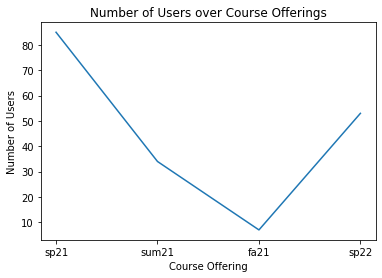

In [41]:
num_users_dict = {"Semester": [], "Number of Users": []}
for i in range(len(data_list)):
    num_users_dict["Semester"].append(data_name_list[i])
    num_users_dict["Number of Users"].append(get_num_users(data_list[i]))

sns.lineplot(x=num_users_dict["Semester"], y=num_users_dict["Number of Users"])
plt.title("Number of Users over Course Offerings")
plt.xlabel("Course Offering")
plt.ylabel("Number of Users");

# Number of Actions Per Session

In [42]:
# Config
BREAK_LEN = 10  # in min

In [43]:
def count_sessions(df, step_only=False):
    '''
    df: df of a specific user, sorted by time
    returns a list of number of actions per session
    '''
    time_diff = df['time'].diff().dt.seconds.div(60, fill_value=float("inf"))
    new_session_start_index = df[time_diff > BREAK_LEN].index.tolist()
    
    actions_per_session = []    
    for i in range(len(new_session_start_index) - 1):
        actions = df.loc[new_session_start_index[i]: new_session_start_index[i + 1]]
        
        if step_only:
            actions = actions[actions["eventType"] == "answerStep"]
            
        actions_per_session.append(len(actions))
        
    actions = df.loc[new_session_start_index[-1] : ]
    if step_only:
        actions = actions[actions["eventType"] == "answerStep"]
    actions_per_session.append(len(actions))
    
    return actions_per_session

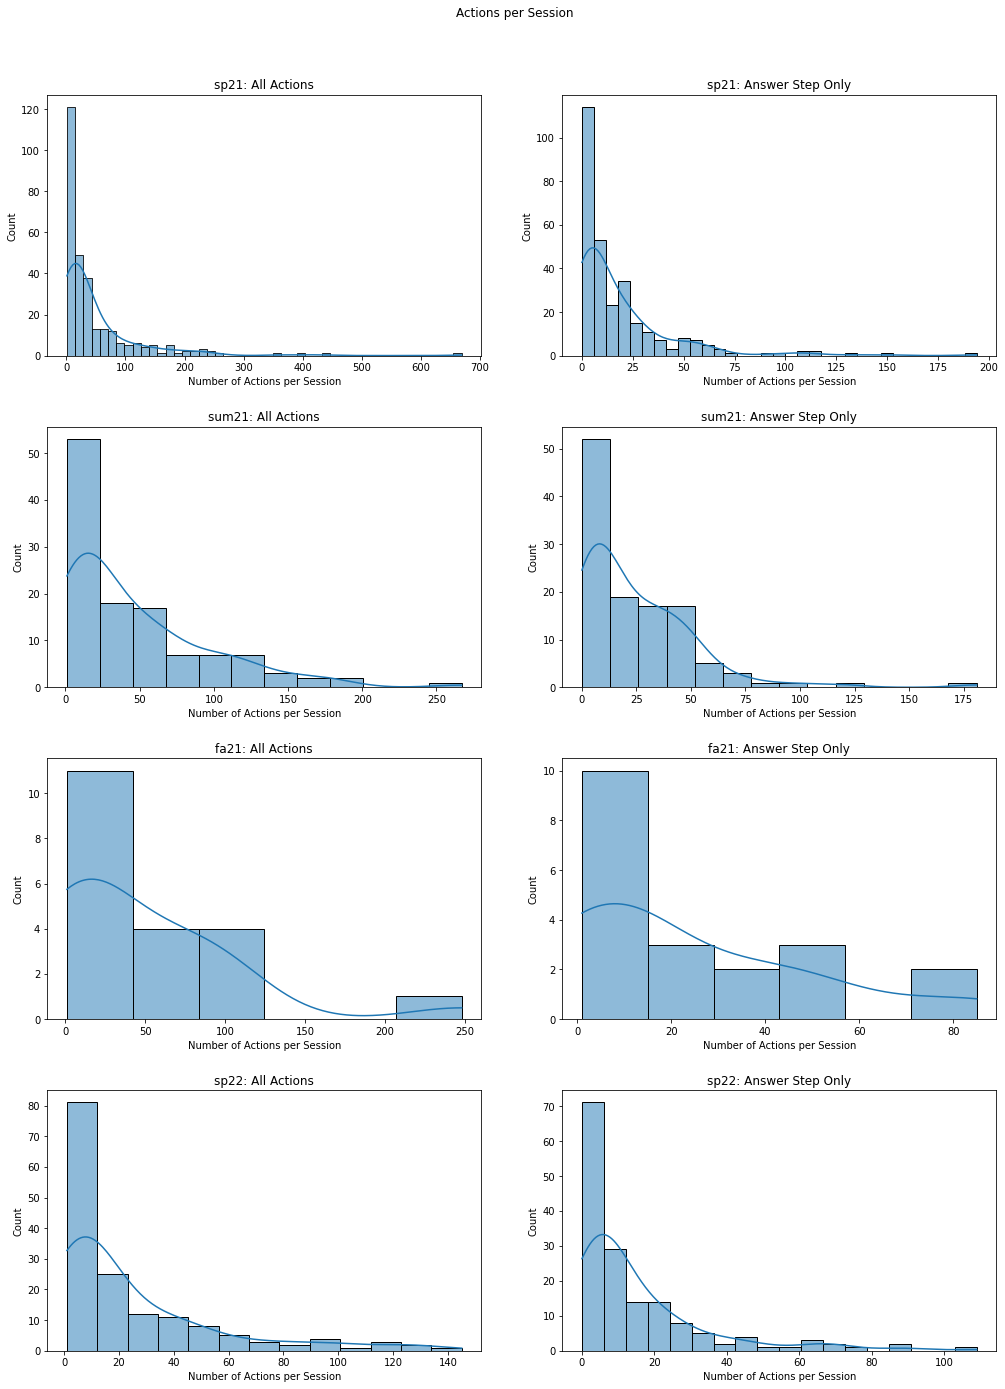

In [44]:
def plot_actions_per_session(df, semester, axes, i, j, step_only=False):
    '''
    df: raw df retrieved from firestore database
    '''
    
    df = df.copy()
    
    actions_per_session_series = df.groupby("oats_user_id").apply(lambda df: count_sessions(df, step_only))
    actions_per_session = sum(actions_per_session_series.tolist(), [])
    
    sns.histplot(actions_per_session, ax=axes[i, j], kde=True)
    if j == 0:
        axes[i, j].set_title(f"{semester}: All Actions")
    else:
        axes[i, j].set_title(f"{semester}: Answer Step Only")
    axes[i, j].set_xlabel("Number of Actions per Session")
    axes[i, j].set_ylabel("Count");

fig, axes = plt.subplots(len(data_list), 2, figsize=(15, 20))
fig.suptitle("Actions per Session")
fig.tight_layout(pad=5)

for i in range(len(data_list)):
    plot_actions_per_session(data_list[i], data_name_list[i], axes, i, 0)
    plot_actions_per_session(data_list[i], data_name_list[i], axes, i, 1, step_only=True)

## Helper graphs for reference

### To determine cutoff of break length between session

In [ ]:
most_used_users = data_list[1].groupby(["oats_user_id"]).size().sort_values(ascending=False)[:5].index.tolist()

for user in most_used_users:
    user_df = data_list[1][data_list[1]["oats_user_id"] == user].sort_values(["time"], ascending=True)
    time_diff = user_df['time'].diff().dt.seconds.div(60, fill_value=0)
    plt.figure()
    plt.figure(figsize=(3,2))
    plt.hist(time_diff, bins=500)
    plt.xlim(0, 60);

### To verify "large" action counts

In [ ]:
df = data_list[0]
s = count_sessions(df)
time_diff = df['time'].diff().dt.seconds.div(60, fill_value=float("inf"))
new_session_start_index = df[time_diff > BREAK_LEN].index.tolist()
idx = new_session_start_index[s.index(max(s))]
t = df.loc[idx]["time"]
df[
   (df["time"] > t + datetime.timedelta(seconds=-3)) & 
   (df["time"] < t + datetime.timedelta(seconds=300))] \
    [["oats_user_id", "hintsFinished", "correctAnswer", "eventType", "problemID", 
      "stepID", "hintID", "hintIsCorrect", "isCorrect", "time"]]

# Length of Each Session

In [17]:
# Config
BREAK_LEN = 10  # in min

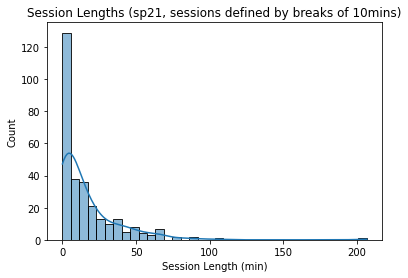

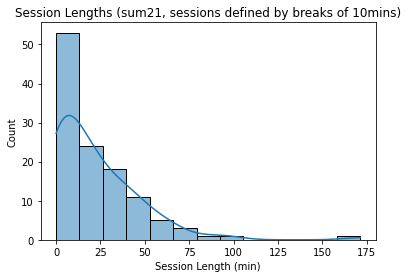

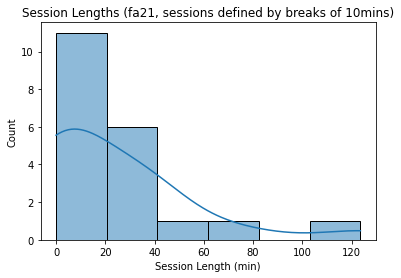

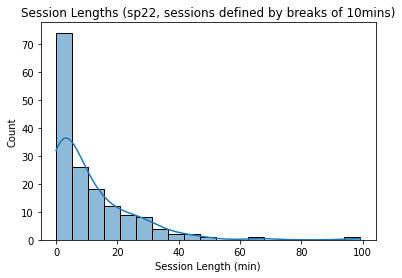

In [18]:
def session_lengths_for_one_user(df):
    '''
    df: df of a specific user, sorted by time
    returns a list of number of actions per session
    '''
    time_diff = df['time'].diff().dt.seconds.div(60, fill_value=float("inf"))
    new_session_start_index = df[time_diff > BREAK_LEN].index.tolist()
    
    session_lengths = []
    for i in range(1, len(new_session_start_index)):
        time_elapsed = (df.iloc[df.index.tolist().index(new_session_start_index[i]) - 1]['time'] - \
                        df.loc[new_session_start_index[i - 1]]['time']).seconds / 60
        session_lengths.append(time_elapsed)
    session_lengths.append((df.iloc[-1]['time'] - \
                            df.loc[new_session_start_index[-1]]['time']).seconds / 60)
    
    return session_lengths

def get_session_lengths(df, semester):
    '''
    df: raw df retrieved from firestore database
    '''
    
    df = df.copy()
    
    session_lengths_series = df.groupby("oats_user_id").apply(session_lengths_for_one_user)
    session_lengths = sum(session_lengths_series.tolist(), [])
    
    plt.figure()
    sns.histplot(session_lengths, kde=True)
    plt.title(f"Session Lengths ({semester}, sessions defined by breaks of {BREAK_LEN}mins)")
    plt.xlabel("Session Length (min)")
    plt.ylabel("Count");


for i in range(len(data_list)):
    get_session_lengths(data_list[i], data_name_list[i])

# Material Usage

In [46]:
def get_lesson_skill(df):
    df = df.copy()
    df = merge_lesson_skill(df)
    
    sheet_df = df.groupby("lesson").size().to_frame().rename(columns={0: "count"})\
                .reset_index().sort_values("lesson", ascending=False)
    sheet_df = sheet_df.merge(df[["lesson", "course"]], 
                              how="left", left_on="lesson", right_on="lesson")\
                .drop_duplicates(subset=["lesson", "course"], keep="first")
    
    skill_df = df.groupby(["skills", "course"]).size().to_frame().rename(columns={0: "count"}).reset_index()
    expanded_skill_df = skill_df["skills"].str.lstrip('[').str.rstrip(']').str.split(',\s').explode().str.strip("'")\
        .drop_duplicates()\
        .to_frame()\
        .reset_index()
    expanded_skill_df = expanded_skill_df.merge(skill_df[["count", "course"]], 
                                                how="left", left_on="index", right_index=True)
    
    return sheet_df, expanded_skill_df

for i in range(len(data_list)):
    lesson_df, skill_df = get_lesson_skill(data_list[i])
    lesson_df = lesson_df[(lesson_df['course'] != "Math 54 Demo") & (lesson_df['course'] != "Biology Demo")]
    skill_df = skill_df[(skill_df['course'] != "Math 54 Demo") & (skill_df['course'] != "Biology Demo")]
    
    fig = px.bar(lesson_df, x='count', y='lesson', color="course", 
                 title=f"{data_name_list[i]} Lesson Counts")
    fig.show()
    
    fig = px.bar(skill_df, x='count', y='skills', color="course", 
                 title=f"{data_name_list[i]} Skill Counts")
    fig.show();

## Overall Skills

In [47]:
lesson_df, skill_df = get_lesson_skill(df_cleared)
skill_df = skill_df[(skill_df['course'] != "Math 54 Demo") & (skill_df['course'] != "Biology Demo")]
skill_df['course'] = pd.Categorical(skill_df['course'],categories=['Data Content', 
                                                                   'Openstax: College Algebra', 
                                                                   'OpenStax: Intermediate Algebra', 
                                                                   'Openstax: Elementary Algebra'],ordered=True)
skill_df = skill_df.sort_values(by=["course", "count"], ascending=True)
fig = px.bar(skill_df, x='count', y='skills', color="course", 
             title=f"Skill Counts for All Semesters", 
             width=2500, height=2000)
fig.show()

## Skills Broken Down by Course

In [48]:
courses = ['Openstax: Elementary Algebra', 'OpenStax: Intermediate Algebra', 
           'Openstax: College Algebra', 'Data Content']

height = {"Openstax: Elementary Algebra": 300, 
          "OpenStax: Intermediate Algebra": 600, 
          "Openstax: College Algebra": 2000, 
          "Data Content": 300}

width = {"Openstax: Elementary Algebra": 900, 
          "OpenStax: Intermediate Algebra": 900, 
          "Openstax: College Algebra": 1500, 
          "Data Content": 400}

for course in courses:
    fig = px.bar(skill_df[skill_df["course"] == course], x='count', y='skills', 
             title=f"Skill Counts for {course}", 
             width=width[course], height=height[course])
    fig.show()

# Number of Students Using Each Lesson

In [49]:
def user_per_lesson(df):
    df = df.copy()
    df = merge_lesson_skill(df)
    count_df = df.groupby(["course", "lesson"])["oats_user_id"].nunique()\
                .to_frame().reset_index()\
                .rename(columns={"oats_user_id": "user_count"})\
                .sort_values("lesson", ascending=False)
    return count_df

# Across all semesters
total_users = user_per_lesson(df_cleared)
fig = px.bar(total_users, x='user_count', y='lesson', color="course", 
             title="Number of User Per Lesson Across All Semesters", 
             height=900)
fig.show();

In [50]:
# Detailed View for each semester
for i in range(4):
    count_df = user_per_lesson(data_list[i])
    fig = px.bar(count_df, x='user_count', y='lesson', color="course", 
             title=f"{data_name_list[i]} Users per Lesson")
    fig.show();

# Number of Users Per Week

In [51]:
def weekly_count(df):
    df = df.copy()
    user_count = df.groupby(pd.Grouper(key='time', freq='W-SUN', convention="end"))\
                    .apply(lambda df: len(df["oats_user_id"].unique()))\
                    .to_frame().reset_index().rename({0: "count"}, axis="columns")
    user_count["time"] = user_count["time"] - pd.offsets.DateOffset(days=7)
    action_count = df.groupby(pd.Grouper(key='time', freq='W-SUN')).apply(lambda df: len(df))\
                    .to_frame().reset_index().rename({0: "count"}, axis="columns")
    action_count["time"] = action_count["time"] - pd.offsets.DateOffset(days=7)
    return user_count, action_count

sp22_weekly_user_count, sp22_weekly_action_count = weekly_count(data_list[3])
fig = px.bar(sp22_weekly_user_count, x='time', y='count',
             title="Sp22 Weekly User Count")
fig.update_xaxes(tickformat="20%y-%m-%d")
fig.show();

fig = px.bar(sp22_weekly_action_count, x='time', y='count',
             title="Sp22 Weekly Action Count")
fig.update_xaxes(tickformat="20%y-%m-%d")
fig.show();

# Operations Associated with Each Lesson

In [128]:
def get_operation_stats(df):
    stats = merge_lesson_skill(df_cleared).groupby(["course", "lesson"])\
                .apply(lambda df: df.value_counts("eventType"))\
                .to_frame()\
                .rename(columns={0: "count"})
    return stats.reset_index()

operation_stats = get_operation_stats(df_cleared)
operation_stats = pd.pivot_table(operation_stats, index=["course", "lesson"], 
                                 columns=["eventType"], values="count", fill_value=0)\
                    .reset_index()

operation_stats['course'] = pd.Categorical(operation_stats['course']
                                           ,categories=['Data Content',
                                                        'Openstax: College Algebra', 
                                                        'OpenStax: Intermediate Algebra', 
                                                        'Openstax: Elementary Algebra'],ordered=True)
operation_stats = operation_stats.sort_values(by=["course", "lesson"], ascending=True)
    
fig = px.bar(operation_stats, y="lesson", x=["answerStep", "unlockHint", "hintScaffoldLog"], 
             title="Operation Stats Per Lesson", width=1000, height=1000)
fig.show()

# Student Activity

In [52]:
BREAK_LEN = 10

In [53]:
def analyze_each_problem(df):
    hint_count = sum(df["eventType"] == "unlockHint")
    step_correct = sum((df["eventType"] == "answerStep") & (df["isCorrect"] == True))
    step_wrong = sum((df["eventType"] == "answerStep") & (df["isCorrect"] != True))
    avg_time_diff = df['time_stamp'].diff().div(1000).median()
    return step_correct, step_wrong, hint_count, avg_time_diff

def get_student_info_by_session(df, uid):
    df = df.copy()
    df = df[df["oats_user_id"] == uid].reset_index()
    df = df[["oats_user_id", "time", "eventType", "problemID", "stepID", "hintID", 
             "isCorrect", "hintsFinished", "time_stamp"]]
    
    time_diff = df['time_stamp'].diff().div(1000 * 60, fill_value=float("inf"))
    new_session_start_index = df[time_diff > BREAK_LEN].index.tolist()
    
    all_session_df = pd.DataFrame()
    
    for i in range(len(new_session_start_index)):
        if i == len(new_session_start_index) - 1:
            session = df.iloc[new_session_start_index[i]: ]
        else:
            session = df.iloc[new_session_start_index[i]: new_session_start_index[i + 1]]
            
        session_info = session.groupby("problemID", sort=False).apply(analyze_each_problem)
        
        session_df = pd.DataFrame()
        
        for j in range(len(session_info)):
            time = session[session["problemID"] == session_info.index[j]].iloc[0]["time"]
            step_correct, step_wrong, hint_count, avg_time_diff = session_info[j]
            session_df = session_df.append({"problem_id": session_info.index[j], "start_time": time, 
                                            "step_correct": step_correct, "step_wrong": step_wrong, 
                                            "hint_count": hint_count, "avg_time_diff (s)": avg_time_diff},
                                           ignore_index=True)
        session_df["session_id"] = i + 1
        
        all_session_df = all_session_df.append(session_df, ignore_index=True)
        
    all_session_df["uid"] = uid
    table = pd.pivot_table(all_session_df, 
                           index=["uid", "session_id", "problem_id", "start_time"], 
                           aggfunc=lambda x: x).sort_values("start_time")
    
    table[["step_correct", "step_wrong", "hint_count"]] = table[["step_correct", "step_wrong", 
                                                                 "hint_count"]].astype(int)
    return table

In [145]:
df_cleared[df_cleared["oats_user_id"] == 47221]

,hintAnswer,semester,hintsFinished,problemID,time_stamp,oats_user_id,siteVersion,stepID,variabilization,hintID,...,correctAnswer,course_id,isCorrect,course_code,input,canvas_user_id,lesson,knowledgeComponents,siteCommitHash,time
0,[],Spring 2021,"[0, 0, 0, 0, 0, 0, 0]",real11,1610772289000,47221,0.2,real11a,{},NaN,...,['180π'],NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-16 04:44:49
1,[],Spring 2021,"[0, 0, 0, 0, 0, 0, 0]",real11,1610772336000,47221,0.2,real11a,{},NaN,...,['180π'],NaN,False,NaN,3,NaN,NaN,NaN,NaN,2021-01-16 04:45:36
3,[],Spring 2021,"[0, 0, 0, 0, 0, 0, 0]",real20,1610773071000,47221,0.2,real20a,{},NaN,...,['64'],NaN,False,NaN,8,NaN,NaN,NaN,NaN,2021-01-16 04:57:51
4,[],Spring 2021,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",poly27,1610780151000,47221,0.2,poly27a,{},NaN,...,['4t^2+x^2+4t-5tx-x'],NaN,False,NaN,x^(2),NaN,NaN,NaN,NaN,2021-01-16 06:55:51
5,[],Spring 2021,"[1, 0, 0, 0, 0, 0, 0, 0, 0]",poly22,1610780175000,47221,0.2,poly22a,{},NaN,...,['9y^2-36y+36'],NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-16 06:56:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11827,[],Spring 2021,"[1, 1, 1]",poly11,1623372578000,47221,1.1,poly11a,{},NaN,...,['$$\\left(81\\right) x^2-\\left(16\\right)$$'],NaN,True,NaN,81*x^(2)+-16,NaN,NaN,NaN,NaN,2021-06-11 00:49:38
11834,[],Spring 2021,"[0, 0, 0, 0]",real16,1623372924000,47221,1.101,real16a,{},NaN,...,['$22'],NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-11 00:55:24
11839,[],Spring 2021,"[0, 0, 0, 0, 0, 0, 0, 0]",real15,1623373023000,47221,1.101,real15a,{},NaN,...,['4'],NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-11 00:57:03
11840,[],Spring 2021,"[0, 0, 0, 0, 0, 0, 0, 0]",real15,1623373046000,47221,1.101,real15a,{},NaN,...,['4'],NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-11 00:57:26


### Activity for One Student

In [54]:
def get_student_activity(df, uid):
    df = df.copy()
    table = get_student_info_by_session(df, uid)
    return table.loc[uid]

table1 = get_student_activity(data_list[1], 34440)
table2 = get_student_activity(data_list[0], 40274)

In [55]:
table1.loc[1]

,,avg_time_diff (s),hint_count,step_correct,step_wrong
problem_id,start_time,,,,
complex19,2021-06-14 06:00:04,1.0,2,1,0
complex1,2021-06-14 06:00:17,NaN,0,1,0
complex27,2021-06-14 06:00:27,7.0,4,1,0


## Activity for All Students

In [56]:
def get_all_activity(df):
    df = df.copy()
    table=pd.DataFrame()
    
    uids = df["oats_user_id"].unique()
    for uid in uids:
        table = table.append(get_student_info_by_session(df, int(uid)))
    
    return table

table = get_all_activity(data_list[0])

In [57]:
table

avg_time_diff (s)  \
uid   session_id problem_id start_time                               
47221 1          real11     2021-01-16 04:44:49               47.0   
      2          real20     2021-01-16 04:57:51                NaN   
      3          poly27     2021-01-16 06:55:51                NaN   
                 poly22     2021-01-16 06:56:15                5.5   
                 poly18     2021-01-16 06:57:28                2.0   
...                                                            ...   
4330  1          RecCord26  2021-06-13 04:29:00                4.5   
                 RecCord25  2021-06-13 04:34:22                3.0   
16367 1          real15     2021-06-13 19:29:29               25.0   
45033 1          RecCord8   2021-06-14 02:34:03              122.0   
                 RecCord6   2021-06-14 02:38:49                NaN   

                                                 hint_count  step_correct  \
uid   session_id problem_id start_time                                      
47221 1          real11     2021-01-16 04:44:49           0             0   
      2          real20     2021-01-16 04:57:51           0             0   
      3          poly27     2021-01-16 06:55:51           0             0   
                 poly22     2021-01-16 06:56:15           3             0   
                 poly18     2021-01-16 06:57:28           1             0   
...                                                     ...           ...   
4330  1          RecCord26  2021-06-13 04:29:00          10             1   
                 RecCord25  2021-06-13 04:34:22           2             0   
16367 1          real15     2021-06-13 19:29:29           3             0   
45033 1          RecCord8   2021-06-14 02:34:03           0             1   
                 RecCord6   2021-06-14 02:38:49           0             1   

                                                 step_wrong  
uid   session_id problem_id start_time                       
47221 1          real11     2021-01-16 04:44:49           2  
      2          real20     2021-01-16 04:57:51           1  
      3          poly27     2021-01-16 06:55:51           1  
                 poly22     2021-01-16 06:56:15           0  
                 poly18     2021-01-16 06:57:28           1  
...                                                     ...  
4330  1          RecCord26  2021-06-13 04:29:00           5  
                 RecCord25  2021-06-13 04:34:22           4  
16367 1          real15     2021-06-13 19:29:29           1  
45033 1          RecCord8   2021-06-14 02:34:03           1  
                 RecCord6   2021-06-14 02:38:49           0  

[1977 rows x 4 columns]